In [94]:
import os
import torch
import trimesh
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm

from extract_edge_features_cuda import compute_edges_properties, batch_simple_edge_features

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
root_dir = 'datasets/simple_edge_features'  # Change this to your actual dataset path
save_dir = 'models/simple_edge_features/'
input_features = 7
num_edges = 512  # Predefined row length (number of rows to keep)
learning_rate = 0.001
batch_size = 32
num_epochs = 10

In [65]:
dataset_root = 'datasets/human'
dataset_indices = {'bouncing': [], 'crane': [], 'handstand': [], 'jumping': [], 'march_1': [], 'march_2': [], 'samba': [], 'squat_1': [], 'squat_2': []}

for root, dirs, files in os.walk(dataset_root):
    if len(files) > 0:
        class_name = root.split('/')[-1]
        dataset_indices[class_name] = [os.path.join(root, file).split('_')[-1].split('.')[0] for file in files]

train_indices = {}
val_indices = {}
test_indices = {}

for class_name in dataset_indices.keys():
    dataset_class_length = len(dataset_indices[class_name])
    train_indices[class_name] = dataset_indices[class_name][:int(0.7 * dataset_class_length)]
    val_indices[class_name] = dataset_indices[class_name][int(0.7 * dataset_class_length):int(0.85 * dataset_class_length)]
    test_indices[class_name] =  dataset_indices[class_name][int(0.85 * dataset_class_length):]


tot_number_of_train_samples = 0
for class_name in train_indices.keys():
    number_of_samples = len(train_indices[class_name])
    tot_number_of_train_samples += number_of_samples
    # print(f'number of samples in {class_name} train: {number_of_samples}')
print(f'total number of train samples: {tot_number_of_train_samples}\n')
    
tot_number_of_val_samples = 0
for class_name in val_indices.keys():
    number_of_samples = len(val_indices[class_name])
    tot_number_of_val_samples += number_of_samples
    # print(f'number of samples in {class_name} val: {number_of_samples}')
print(f'total number of val samples: {tot_number_of_val_samples}\n')

tot_number_of_test_samples = 0
for class_name in test_indices.keys():
    number_of_samples = len(test_indices[class_name])
    tot_number_of_test_samples += number_of_samples
    # print(f'number of samples in {class_name} test: {number_of_samples}')
print(f'total number of test samples: {tot_number_of_test_samples}\n')

total number of train samples: 1293

total number of val samples: 274

total number of test samples: 283



In [91]:
class EdgesFeaturesDataset(Dataset):
    def __init__(self, root_dir, indices, num_edges, transform=None):
        self.root_dir = root_dir
        self.indices = indices
        self.num_edges = num_edges
        self.transform = transform
        self.samples = []

        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            class_name = class_dir.split('/')[-1]
            class_indices = self.indices[class_name]
            if os.path.isdir(class_dir):
                files = [f for f in os.listdir(class_dir) if f.endswith('.pt')]
                for file in files:
                    file_index = file.split('_')[-1].split('.')[0]
                    if file_index not in class_indices: 
                      print(file_index)
                      continue
                    path = os.path.join(class_dir, file)
                    label = class_name
                    self.samples.append((path, label))

        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(set([s[1] for s in self.samples])))}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        label_idx = self.class_to_idx[label]
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        edge_features_tensor = torch.load(path, weights_only=True)  # edge_features_Tensor shape is (N, 7)

        if edge_features_tensor.shape[0] >= self.num_edges:
            edge_features_tensor = edge_features_tensor[:self.num_edges, :]
        else:
            padding = torch.zeros((self.num_edges - edge_features_tensor.shape[0], edge_features_tensor.shape[1]))
            edge_features_tensor = torch.cat((edge_features_tensor, padding), dim=0)

        if self.transform:
            edge_features_tensor = self.transform(edge_features_tensor)

        edge_features_tensor = edge_features_tensor.clone().detach().float()

        return edge_features_tensor, label_tensor

In [98]:
class MeshDataset(Dataset):
    def __init__(self, root_dir, indices, num_edges, transform=None):
        self.root_dir = root_dir
        self.indices = indices
        self.num_edges = num_edges
        self.transform = transform
        self.samples = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            class_name = class_dir.split('/')[-1]
            class_indices = self.indices[class_name]
            if os.path.isdir(class_dir):
                files = [f for f in os.listdir(class_dir) if f.endswith('.obj')]
                for file in files:
                    file_index = file.split('_')[-1].split('.')[0]
                    if file_index not in class_indices: continue
                    path = os.path.join(class_dir, file)
                    label = class_name
                    self.samples.append((path, label))

        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(set([s[1] for s in self.samples])))}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        label_idx = self.class_to_idx[label]
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        
        mesh = trimesh.load_mesh(path)
        edge_properties = compute_edges_properties(mesh)
        edge_features_tensor = batch_simple_edge_features(edge_properties, device=self.device)
                
        if edge_features_tensor.shape[0] >= self.num_edges:
            edge_features_tensor = edge_features_tensor[:self.num_edges, :]
        else:
            padding = torch.zeros((self.num_edges - edge_features_tensor.shape[0], edge_features_tensor.shape[1]))
            edge_features_tensor = torch.cat((edge_features_tensor, padding), dim=0)

        if self.transform:
            edge_features_tensor = self.transform(edge_features_tensor)

        edge_features_tensor = edge_features_tensor.clone().detach().float()

        return edge_features_tensor, label_tensor

In [67]:
# Define a simple CNN model
class MeshEdgesCNN(nn.Module):
  def __init__(self, num_classes, input_features, num_edges=1024):
    super(MeshEdgesCNN, self).__init__()
    
    self.conv1 = nn.Conv1d(in_channels=input_features, out_channels=8, kernel_size=3, padding=1)
    self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
    self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

    self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(32 * (num_edges // 8), 128)  # Adjust size after pooling
    self.fc2 = nn.Linear(128, num_classes)

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = x.permute(0, 2, 1)  # Convert (batch_size, num_edges, 7) to (batch_size, 7, num_edges)

    x = self.pool(self.relu(self.conv1(x)))  # (batch_size, 16, num_edges/2)
    x = self.pool(self.relu(self.conv2(x)))  # (batch_size, 32, num_edges/4)
    x = self.pool(self.relu(self.conv3(x)))  # (batch_size, 64, num_edges/8)

    x = x.view(x.size(0), -1)  # (batch_size, 64 * (num_edges // 8))

    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [68]:
train_dataset = EdgesFeaturesDataset(root_dir, train_indices, num_edges)
val_dataset = EdgesFeaturesDataset(root_dir, val_indices, num_edges)
test_dataset = EdgesFeaturesDataset(root_dir, test_indices, num_edges)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.class_to_idx)

In [69]:
model = MeshEdgesCNN(num_classes=num_classes, input_features=input_features, num_edges=num_edges)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [70]:
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(torch.float32), labels.to(torch.long)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(torch.float32), labels.to(torch.long)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f'Epoch {epoch+1}/{num_epochs}, '
        f'Train Loss: {running_loss/len(train_loader):.4f}, '
        f'Validation Loss: {val_loss/len(val_loader):.4f}, '
        f'Validation Accuracy: {100 * correct / total:.2f}%')
  
  torch.save(model.state_dict(), save_dir + f'checkpoints/simple_edge_features_{epoch}.pth')
  
torch.save(model.state_dict(), save_dir + 'simple_edge_features.pth')

Epoch 1/10, Train Loss: 2.0455, Validation Loss: 1.6487, Validation Accuracy: 53.28%
Epoch 2/10, Train Loss: 1.2722, Validation Loss: 0.8065, Validation Accuracy: 74.82%
Epoch 3/10, Train Loss: 0.7658, Validation Loss: 0.4786, Validation Accuracy: 85.40%
Epoch 4/10, Train Loss: 0.4984, Validation Loss: 0.2980, Validation Accuracy: 92.70%
Epoch 5/10, Train Loss: 0.3545, Validation Loss: 0.2084, Validation Accuracy: 94.89%
Epoch 6/10, Train Loss: 0.2696, Validation Loss: 0.1704, Validation Accuracy: 94.16%
Epoch 7/10, Train Loss: 0.2067, Validation Loss: 0.1469, Validation Accuracy: 96.35%
Epoch 8/10, Train Loss: 0.1697, Validation Loss: 0.0982, Validation Accuracy: 98.18%
Epoch 9/10, Train Loss: 0.1495, Validation Loss: 0.1316, Validation Accuracy: 94.16%
Epoch 10/10, Train Loss: 0.1342, Validation Loss: 0.1256, Validation Accuracy: 96.35%


Test Accuracy: 96.47%


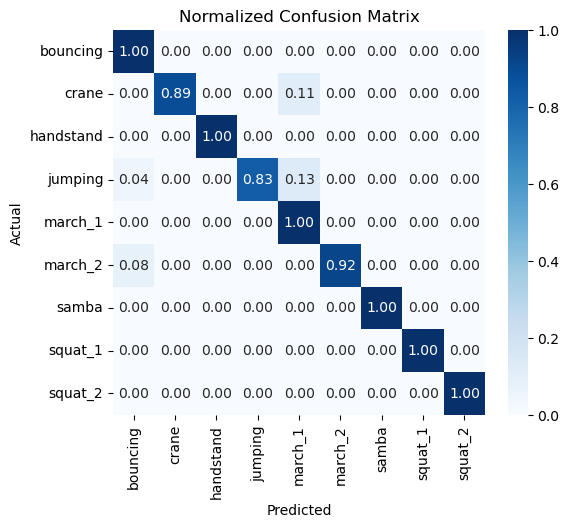

bouncing: Precision=0.89, Recall=1.00, F1-Score=0.94
crane: Precision=1.00, Recall=0.89, F1-Score=0.94
handstand: Precision=1.00, Recall=1.00, F1-Score=1.00
jumping: Precision=1.00, Recall=0.83, F1-Score=0.90
march_1: Precision=0.81, Recall=1.00, F1-Score=0.89
march_2: Precision=1.00, Recall=0.92, F1-Score=0.96
samba: Precision=1.00, Recall=1.00, F1-Score=1.00
squat_1: Precision=1.00, Recall=1.00, F1-Score=1.00
squat_2: Precision=1.00, Recall=1.00, F1-Score=1.00


In [72]:
test_model = MeshEdgesCNN(num_classes=num_classes, input_features=input_features, num_edges=num_edges)
test_model.load_state_dict(torch.load(save_dir+'simple_edge_features.pth', weights_only=True))
test_model.eval()

correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for point_clouds, labels in test_loader:
        outputs = model(point_clouds)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

cm = confusion_matrix(y_true, y_pred, normalize='true')  # Normalize over the true labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=test_dataset.idx_to_class.values(), yticklabels=test_dataset.idx_to_class.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# Compute Precision, Recall and F1-Score
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * precision * recall / (precision + recall)

for i, cls_name in test_dataset.idx_to_class.items():
    print(f'{cls_name}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1-Score={f1_score[i]:.2f}')

In [102]:
test_dataset_mesh = MeshDataset(dataset_root, test_indices, num_edges)
test_loader_mesh = DataLoader(test_dataset_mesh, batch_size=batch_size, shuffle=False)

test_model = MeshEdgesCNN(num_classes=num_classes, input_features=input_features, num_edges=num_edges)
test_model.load_state_dict(torch.load(save_dir+'simple_edge_features.pth', weights_only=True))
test_model.eval()

correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():    
    for data, labels in tqdm(test_loader_mesh, desc="Testing"):
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

cm = confusion_matrix(y_true, y_pred, normalize='true')  # Normalize over the true labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=test_dataset.idx_to_class.values(), yticklabels=test_dataset.idx_to_class.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# Compute Precision, Recall and F1-Score
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * precision * recall / (precision + recall)

for i, cls_name in test_dataset.idx_to_class.items():
    print(f'{cls_name}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1-Score={f1_score[i]:.2f}')

Testing:   0%|          | 0/9 [00:48<?, ?it/s]


KeyboardInterrupt: 